In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tikzplotlib
import gpflow
from docs.sde.sde_exp_utils import bitmappify
import pandas

2022-08-15 19:29:18.773029: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 19:29:18.773057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-15 19:29:21.438197: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-15 19:29:21.442864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-15 19:29:21.473108: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-15 19:29:21.473136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-15 19:29:21.473143: I tensorflow/stream_execut

In [2]:
seed_id = 12
main_dir = r"../data/gpu_training/" + str(seed_id)

generate_tex = False
output_dir = r"fig/DW/" + str(seed_id)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
extra_axis_parameters = ["axis x line=bottom", "axis y line=left"]

In [3]:
def list_to_str(lst):
    return str(lst).replace("[", "{").replace("]", "}")

## Plot Data

In [4]:
data_path = os.path.join(main_dir, "data.npz")
data = np.load(data_path)

In [5]:
latent_process = data["latent_process"]
noise_var = data["noise_stddev"]**2
q = data["q"]
time_grid = data["time_grid"]
x0 = data["x0"]
observation_data = (data["observation_grid"].reshape((-1,)), data["observation_vals"].reshape((-1, 1)))
test_data = (data["test_grid"].reshape((-1, )), data["test_vals"].reshape((-1, 1)))

t0 = time_grid[0]
t1 = time_grid[-1]

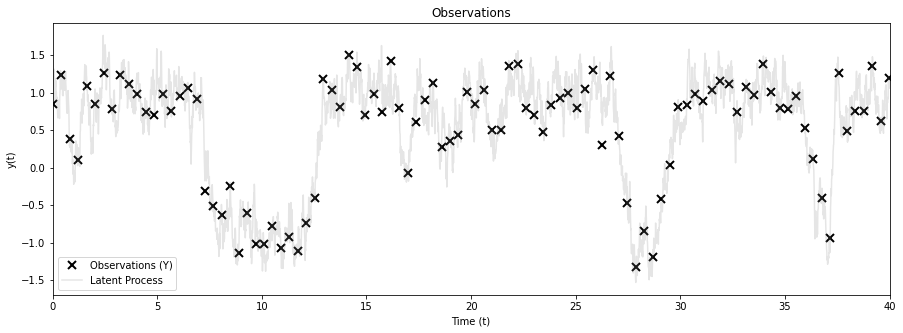

In [6]:
plt.subplots(1, 1, figsize=(15, 5))

plt.plot(observation_data[0].reshape(-1), observation_data[1].reshape(-1), 
         'kx', ms=8, mew=2, label="Observations (Y)")
plt.plot(time_grid, latent_process.reshape(-1), label="Latent Process", alpha=0.2, color="gray")
# plt.plot(test_data[0].reshape(-1), test_data[1].reshape(-1), 'x', color="red", ms=8, mew=2,
#          label="Test Observations (Y)")
plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.title("Observations")
plt.legend()
plt.show()

## Plot ELBO

In [7]:
ssm_1_path = os.path.join(main_dir, "inference_0.01", "ssm_elbo.npz")
ssm_5_path = os.path.join(main_dir, "inference_0.005", "ssm_elbo.npz")
ssm_01_path = os.path.join(main_dir, "inference_0.001", "ssm_elbo.npz")

ssm_1_elbo = np.load(ssm_1_path)["elbo"]
ssm_5_elbo = np.load(ssm_5_path)["elbo"]
ssm_01_elbo = np.load(ssm_01_path)["elbo"]

In [8]:
vgp_1_path = os.path.join(main_dir, "inference_0.01", "vgp_elbo.npz")
vgp_5_path = os.path.join(main_dir, "inference_0.005", "vgp_elbo.npz")
vgp_01_path = os.path.join(main_dir, "inference_0.001", "vgp_elbo.npz")

vgp_1_elbo = np.load(vgp_1_path)["elbo"]
vgp_5_elbo = np.load(vgp_5_path)["elbo"]
vgp_01_elbo = np.load(vgp_01_path)["elbo"]

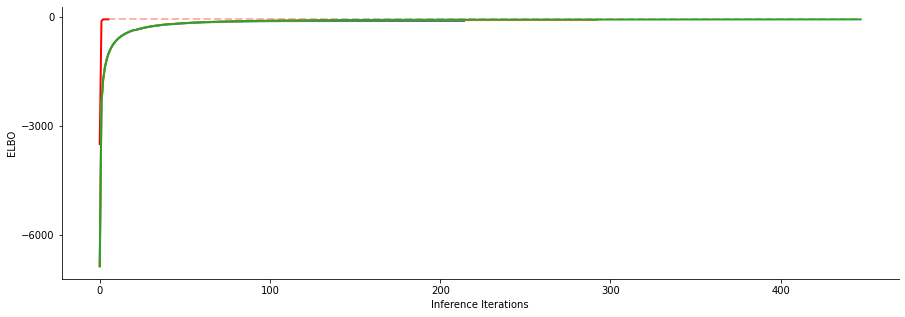

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(ssm_1_elbo, label="t-VGP(dt=0.01)", linewidth=2., color="red")
# plt.plot(ssm_5_elbo, label="Proposed method (dt=0.005)")
# plt.plot(ssm_01_elbo, label="Proposed method (dt=0.001)")

plt.plot(vgp_1_elbo, label="VGP (dt=0.01)", linewidth=2.)
plt.plot(vgp_5_elbo, label="VGP (dt=0.005)", linewidth=2.)
plt.plot(vgp_01_elbo, label="VGP (dt=0.001)", linewidth=2.)

plt.hlines(ssm_1_elbo[-1], len(ssm_1_elbo)-1, len(vgp_01_elbo)-1, color="red", linestyle="dashed", linewidth=2.,
          alpha=0.3)

# plt.xlim([-5, len(vgp_01_elbo) + 10])
# plt.ylim([vgp_01_elbo[0], 100])


axis_parameters = extra_axis_parameters.copy()
if seed_id == 12:
    x_ticks = [0, 100, 200, 300, 400]
    y_ticks = [0, -3000, -6000]

elif seed_id==33:
    x_ticks = [0, 110, 220, 330, 440 , 550]
#     y_ticks = [-5000, -35000, -70000]
    y_ticks = [-300, -700]
    plt.xlim([-20, 610])
    plt.ylim([-800, -200])
    
    
plt.xticks(x_ticks)
plt.yticks(y_ticks)

axis_parameters.append("xtick="+list_to_str(x_ticks))
axis_parameters.append("ytick="+list_to_str(y_ticks))

    
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.xlabel("Inference Iterations")
plt.ylabel("ELBO")
# plt.legend()

if generate_tex:
    tikzplotlib.save(os.path.join(output_dir, 'elbo_iterations.tex'), figure=fig, axis_width="\\figurewidth",
                     axis_height="\\figureheight", extra_axis_parameters=axis_parameters)

plt.show()

<Figure size 432x288 with 0 Axes>

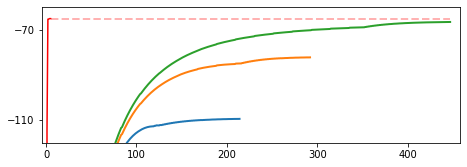

In [10]:
plt.clf()
fig, _ = plt.subplots(1, 1, figsize=(7.5, 2.5))

plt.plot(ssm_1_elbo, label="t-VGP (dt=0.01)", color="red", zorder=3.)
# plt.plot(ssm_5_elbo, label="Proposed method (dt=0.005)")
# plt.plot(ssm_01_elbo, label="Proposed method (dt=0.001)")

plt.plot(vgp_1_elbo, label="VGP (dt=0.01)", linewidth=2.)
plt.plot(vgp_5_elbo, label="VGP (dt=0.005)", linewidth=2.)
plt.plot(vgp_01_elbo, label="VGP (dt=0.001)", linewidth=2.)

plt.hlines(ssm_1_elbo[-1], len(ssm_1_elbo)-1, len(vgp_01_elbo)-1, color="red", linestyle="dashed", linewidth=2.,
          alpha=0.3)

axis_parameters = extra_axis_parameters.copy()
if seed_id == 12:
    x_ticks = [0, 100, 200, 300, 400]
    y_ticks = [-110, -70]

    plt.ylim([-120, -60])
    
elif seed_id==33:
    x_ticks = [0, 110, 220, 330, 440 , 550]
    y_ticks = [-300, -700]
    
    plt.ylim([-800, -200])
    
plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.xlim([-5, len(vgp_01_elbo) + 10])

axis_parameters.append("xtick="+list_to_str(x_ticks))
axis_parameters.append("ytick="+list_to_str(y_ticks))

if generate_tex:
     tikzplotlib.save(os.path.join(output_dir, 'elbo_iterations_zoom.tex'), figure=fig, axis_width="\\figurewidth",
                      axis_height="\\figureheight", extra_axis_parameters=axis_parameters)
plt.show()

## Plot Posterior

In [11]:
ssm_inf_1_path = os.path.join(main_dir, "inference_0.01", "ssm_inference.npz")

ssm_inf_1_m = np.load(ssm_inf_1_path)["m"]
ssm_inf_1_S = np.load(ssm_inf_1_path)["S"]
ssm_inf_1_S_std = np.sqrt(ssm_inf_1_S)

In [12]:
vgp_inf_1_path = os.path.join(main_dir, "inference_0.01", "vgp_inference.npz")

vgp_inf_1_m = np.load(vgp_inf_1_path)["m"]
vgp_inf_1_S = np.load(vgp_inf_1_path)["S"]
vgp_inf_1_S_std = np.sqrt(vgp_inf_1_S)

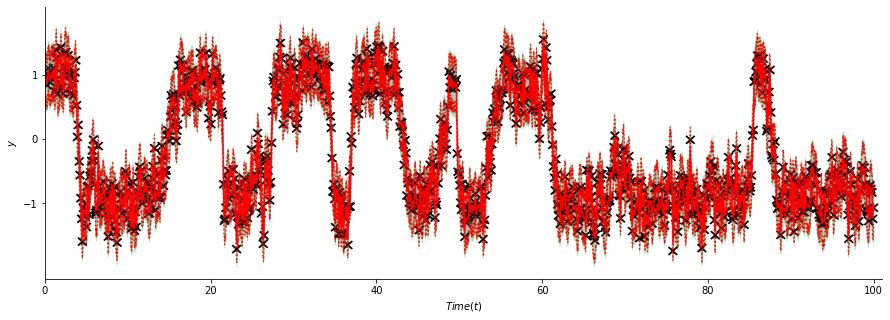

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))


plt.plot(observation_data[0].reshape(-1), observation_data[1].reshape(-1), 
         'kx', ms=8, mew=2, label="Observations (Y)")
plt.plot(time_grid, latent_process.reshape(-1), alpha=0.2, color="gray")


plt.fill_between(
    time_grid,
    y1=(ssm_inf_1_m.reshape(-1) - 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ),
    y2=(ssm_inf_1_m.reshape(-1) + 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ),
    alpha=.2,
    color="gray"
)
plt.fill_between(
    time_grid,
    y1=(vgp_inf_1_m.reshape(-1) - 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ),
    y2=(vgp_inf_1_m.reshape(-1) + 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ),
    alpha=.2,
    color="green"
)
plt.plot(time_grid.reshape(-1), (ssm_inf_1_m.reshape(-1) - 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="red")
plt.plot(time_grid.reshape(-1), (ssm_inf_1_m.reshape(-1) + 2 * ssm_inf_1_S_std.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="red")
# plt.plot(time_grid.reshape(-1), (vgp_inf_1_m.reshape(-1) - 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ), 
#          linestyle=(0, (5, 10)), color="green")
# plt.plot(time_grid.reshape(-1), (vgp_inf_1_m.reshape(-1) + 2 * vgp_inf_1_S_std.reshape(-1)).reshape(-1, ), 
#          linestyle=(0, (5, 10)), color="green")

if seed_id==33:
    plt.plot(time_grid.reshape(-1), ssm_inf_1_m.reshape(-1), label="t-VGP", color="red")

#     plt.plot(time_grid.reshape(-1), vgp_inf_1_m.reshape(-1), linestyle="dashed", 
#              color="green", label="VGP")
#     plt.legend()
    
if generate_tex:
    bitmappify(ax, dpi=300)

if seed_id==12:    
    plt.plot(time_grid.reshape(-1), ssm_inf_1_m.reshape(-1), label="t-VGP", color="red")
    
    plt.plot(time_grid.reshape(-1), vgp_inf_1_m.reshape(-1), linestyle="dashed", 
             color="green", label="VGP")
    plt.legend()
    
plt.xlim([t0, t1+1])
# plt.grid(True)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

if seed_id==12:
    x_ticks = [0, 10, 20, 30, 40]
    y_ticks = [-1, 0, 1]
    
elif seed_id==33:
    x_ticks = [0, 20, 40, 60, 80, 100]
    y_ticks = [-1, 0, 1]

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

axis_parameters = extra_axis_parameters.copy()
axis_parameters.append("xtick="+list_to_str(x_ticks))
axis_parameters.append("ytick="+list_to_str(y_ticks))

plt.ylabel("$y$")
plt.xlabel("$Time (t)$")

if generate_tex:

    tikzplotlib.save(os.path.join(output_dir, 'posterior.tex'), figure=fig, axis_width="\\figurewidth",
                     axis_height="\\figureheight", extra_axis_parameters=axis_parameters)
plt.show()

## Plot Components of ELBO

In [14]:
model_type = "learning"  # learning, inference

In [15]:
ssm_elbo_lin_loss_path = os.path.join(main_dir, model_type + "_0.01", "ssm-lin-loss.csv")
ssm_elbo_cross_term_path = os.path.join(main_dir, model_type + "_0.01", "ssm-cross-term.csv")
ssm_elbo_ve_path = os.path.join(main_dir, model_type + "_0.01", "ssm-ve.csv")
ssm_elbo_kl_path = os.path.join(main_dir, model_type + "_0.01", "ssm-kl.csv")

In [16]:
df = pandas.read_csv(ssm_elbo_lin_loss_path)
ssm_elbo_lin_loss = df[df.columns[1]].to_numpy()[4:]

df = pandas.read_csv(ssm_elbo_cross_term_path)
ssm_elbo_cross_term = df[df.columns[1]].to_numpy()[4:]

df = pandas.read_csv(ssm_elbo_ve_path)
ssm_elbo_ve = df[df.columns[1]].to_numpy()[4:]

df = pandas.read_csv(ssm_elbo_kl_path)
ssm_elbo_kl = df[df.columns[1]].to_numpy()[4:]

x = np.linspace(0, len(ssm_elbo_ve)-1, len(ssm_elbo_ve))

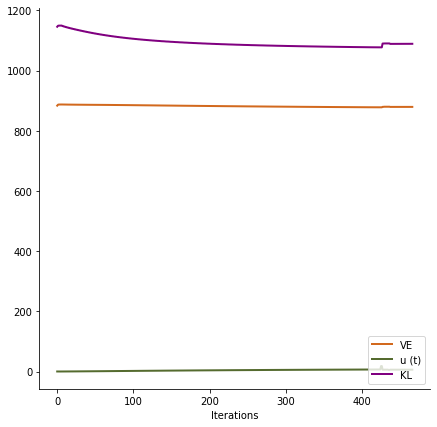

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plt.plot(x, ssm_elbo_ve, linewidth=2., label="VE", color="chocolate")
plt.plot(x, ssm_elbo_lin_loss + ssm_elbo_cross_term, linewidth=2., label="u (t)", color="darkolivegreen")
plt.plot(x, ssm_elbo_kl, linewidth=2., label="KL", color="purple")

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plt.xticks([0, 3, 5])
plt.xlabel("Iterations")

# plt.ylim([-1000, 100])

plt.legend(loc="lower right")
if generate_tex:
    tikzplotlib.save(os.path.join(output_dir, 'elbo_components_' + model_type + '.tex'), figure=fig, axis_width="\\figurewidth",
                 axis_height="\\figureheight", extra_axis_parameters=["axis x line=bottom", "axis y line=left"])

plt.show()